In [1]:
import numpy as np
import matplotlib.pyplot as plt

(20, 7)
(20, 1)


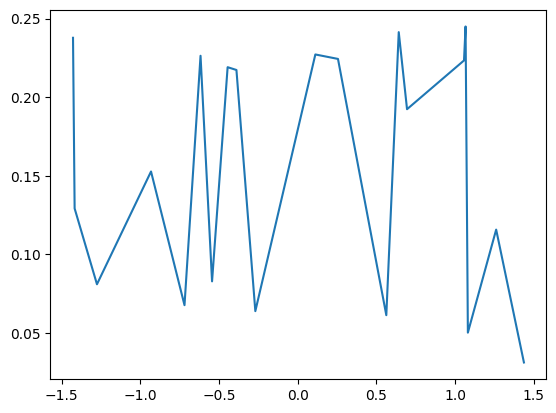

In [39]:
batch = np.load("currentData/batch1.npz")

print(batch["inputs"].shape)
print(batch["outputs"].shape)

plt.plot(np.sort(batch["inputs"][:,0]), batch["outputs"])